# Supercompressible: regression 3d (energy absorbed)

This notebook intends to show the application of neural networs to make predictions about the energy absorbed in the supercompressible example. In particular, the 7d case will be considered.

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Now, let's import the data.

In [2]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
points = data['points']
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values

# get y data
var_name = 'energy'
y = points.loc[:, var_name].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (10000, 3)
y: [2.79529996e-04            nan 1.42853201e+01 ...            nan
            nan            nan]
y shape: (10000,)


The variables ```X``` and ```y``` contain all the data. Nevertheless, there's ```NaN``` values that cannot be considered.

In [3]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get y data
y = points.loc[indices, var_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.0686875  0.328125   0.55      ]
 ...
 [0.06900336 0.30805969 0.68618164]
 [0.03450336 0.93305969 0.28618164]
 [0.02587836 0.46430969 0.18618164]]
X shape: (5264, 3)
y: [2.79529996e-04 1.42853201e+01 3.99711660e+01 ... 5.35333775e+01
 2.35352031e+00 6.15239445e-01]
y shape: (5264,)


Let's now clean the data.

In [4]:
def perform_cleaning(X, y, n_std_cleaning):
    
    # compute threshold
    y_mean, y_std = np.mean(y), np.std(y)
    y_thresh = y_mean + n_std_cleaning * y_std

    # indices
    print(y_thresh)
    indices = np.where(y < y_thresh)
    n_dismissed_points = len(y) - len(indices[0])
    print('Dismissed points:', n_dismissed_points)

    # X and y
    y = y[indices]
    X = X[indices]
    print(np.shape(y))
    print(np.shape(X))

    return X, y, n_dismissed_points

In [5]:
n_std_cleaning = 5  # dismiss points that fall outside this range

n_dismissed_points = 1
while n_dismissed_points > 0:
    X, y, n_dismissed_points = perform_cleaning(X, y, n_std_cleaning)

251.41209785647746
Dismissed points: 6
(5258,)
(5258, 3)
78.83845527943124
Dismissed points: 7
(5251,)
(5251, 3)
76.83459344264611
Dismissed points: 0
(5251,)
(5251, 3)


Text(0, 0.5, 'Frequency')

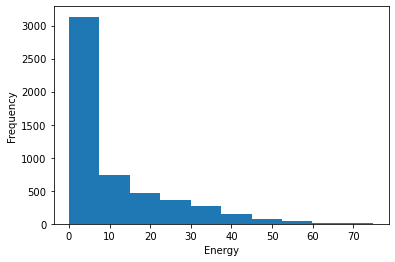

In [6]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

Before starting to make predictions, let's create a function that to train a neural network. Let's also create functions to split the data and to print the error metrics and plot the predicted values against the observed values.

In [7]:
def make_nn(X_train, y_train, validation_data, n_neurons=(400, 400, 400), activations='relu'):
    
    # initialization
    if type(activations) is str:
        activations = [activations] * len(n_neurons)
           
    # set model
    model = Sequential()
    for i, (n_neurons_, activation) in enumerate(zip(n_neurons, activations)):
        model.add(Dense(n_neurons_, activation=activation))
    model.add(Dense(1))
    
    # set optimizer
    optimizer = optimizers.Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    # set early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=10.0, patience=10)
    
    # fit the model
    history = model.fit(X_train, y_train, epochs=1000, batch_size=1000, validation_data=validation_data)
                    
    return model, history

In [8]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [9]:
def evaluate_model(model, X_test, y_test, n_train):
    
    # predict test
    y_pred = model.predict(X_test)

    # error metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    expl_var = explained_variance_score(y_test, y_pred)
    print("The mean squared error is %0.3e" % mse)
    print("The R2 score is %0.3f" % r2)
    print("The explained variance score is %0.3f" % expl_var)

    # plot predicted vs observed
    plt.figure()
    plt.plot(y_test, y_pred, 'o')
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r-')
    plt.title('$n_{train} = %i$, $R^{2} = %0.3f$, $ MSE = %0.3e$' % (n_train, r2, mse))
    plt.ylabel("Predicted")
    plt.xlabel("Observed")
    plt.show()

So, let's split the data and start to make some predictions!

In [10]:
# split data
train_size = .1
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
model, history = make_nn(X_train_scaled, y_train, (X_test_scaled, y_test))

Train on 525 samples, validate on 4726 samples
Epoch 1/1000
525/525 [==============================] - 0s 789us/step - loss: 262.0116 - val_loss: 284.6147
Epoch 2/1000
525/525 [==============================] - 0s 42us/step - loss: 261.2516 - val_loss: 283.8223
Epoch 3/1000
525/525 [==============================] - 0s 42us/step - loss: 260.4862 - val_loss: 283.0214
Epoch 4/1000
525/525 [==============================] - 0s 44us/step - loss: 259.7129 - val_loss: 282.2113
Epoch 5/1000
525/525 [==============================] - 0s 40us/step - loss: 258.9314 - val_loss: 281.3915
Epoch 6/1000
525/525 [==============================] - 0s 46us/step - loss: 258.1406 - val_loss: 280.5614
Epoch 7/1000
525/525 [==============================] - 0s 40us/step - loss: 257.3391 - val_loss: 279.7206
Epoch 8/1000
525/525 [==============================] - 0s 40us/step - loss: 256.5265 - val_loss: 278.8665
Epoch 9/1000
525/525 [==============================] - 0s 44us/step - loss: 255.7014 - val_loss

Epoch 77/1000
525/525 [==============================] - 0s 32us/step - loss: 101.6196 - val_loss: 113.7399
Epoch 78/1000
525/525 [==============================] - 0s 36us/step - loss: 98.4458 - val_loss: 110.3707
Epoch 79/1000
525/525 [==============================] - 0s 38us/step - loss: 95.3219 - val_loss: 107.0515
Epoch 80/1000
525/525 [==============================] - 0s 38us/step - loss: 92.2514 - val_loss: 103.7864
Epoch 81/1000
525/525 [==============================] - 0s 38us/step - loss: 89.2377 - val_loss: 100.5793
Epoch 82/1000
525/525 [==============================] - 0s 44us/step - loss: 86.2844 - val_loss: 97.4330
Epoch 83/1000
525/525 [==============================] - 0s 38us/step - loss: 83.3939 - val_loss: 94.3500
Epoch 84/1000
525/525 [==============================] - 0s 38us/step - loss: 80.5695 - val_loss: 91.3340
Epoch 85/1000
525/525 [==============================] - 0s 38us/step - loss: 77.8142 - val_loss: 88.3867
Epoch 86/1000
525/525 [=================

Epoch 154/1000
525/525 [==============================] - 0s 38us/step - loss: 11.0836 - val_loss: 14.2073
Epoch 155/1000
525/525 [==============================] - 0s 40us/step - loss: 10.9361 - val_loss: 14.0290
Epoch 156/1000
525/525 [==============================] - 0s 40us/step - loss: 10.7932 - val_loss: 13.8568
Epoch 157/1000
525/525 [==============================] - 0s 38us/step - loss: 10.6548 - val_loss: 13.6902
Epoch 158/1000
525/525 [==============================] - 0s 40us/step - loss: 10.5205 - val_loss: 13.5290
Epoch 159/1000
525/525 [==============================] - 0s 38us/step - loss: 10.3901 - val_loss: 13.3728
Epoch 160/1000
525/525 [==============================] - 0s 36us/step - loss: 10.2634 - val_loss: 13.2212
Epoch 161/1000
525/525 [==============================] - 0s 47us/step - loss: 10.1402 - val_loss: 13.0739
Epoch 162/1000
525/525 [==============================] - 0s 49us/step - loss: 10.0203 - val_loss: 12.9308
Epoch 163/1000
525/525 [=============

Epoch 232/1000
525/525 [==============================] - 0s 40us/step - loss: 5.4561 - val_loss: 7.6715
Epoch 233/1000
525/525 [==============================] - 0s 38us/step - loss: 5.4205 - val_loss: 7.6304
Epoch 234/1000
525/525 [==============================] - 0s 40us/step - loss: 5.3853 - val_loss: 7.5898
Epoch 235/1000
525/525 [==============================] - 0s 40us/step - loss: 5.3506 - val_loss: 7.5497
Epoch 236/1000
525/525 [==============================] - 0s 40us/step - loss: 5.3164 - val_loss: 7.5102
Epoch 237/1000
525/525 [==============================] - 0s 34us/step - loss: 5.2828 - val_loss: 7.4713
Epoch 238/1000
525/525 [==============================] - 0s 34us/step - loss: 5.2496 - val_loss: 7.4329
Epoch 239/1000
525/525 [==============================] - 0s 36us/step - loss: 5.2169 - val_loss: 7.3950
Epoch 240/1000
525/525 [==============================] - 0s 34us/step - loss: 5.1847 - val_loss: 7.3577
Epoch 241/1000
525/525 [==============================]

Epoch 311/1000
525/525 [==============================] - 0s 42us/step - loss: 3.7600 - val_loss: 5.6685
Epoch 312/1000
525/525 [==============================] - 0s 40us/step - loss: 3.7483 - val_loss: 5.6538
Epoch 313/1000
525/525 [==============================] - 0s 38us/step - loss: 3.7367 - val_loss: 5.6392
Epoch 314/1000
525/525 [==============================] - 0s 42us/step - loss: 3.7252 - val_loss: 5.6249
Epoch 315/1000
525/525 [==============================] - 0s 34us/step - loss: 3.7138 - val_loss: 5.6106
Epoch 316/1000
525/525 [==============================] - 0s 36us/step - loss: 3.7025 - val_loss: 5.5966
Epoch 317/1000
525/525 [==============================] - 0s 36us/step - loss: 3.6914 - val_loss: 5.5827
Epoch 318/1000
525/525 [==============================] - 0s 40us/step - loss: 3.6803 - val_loss: 5.5689
Epoch 319/1000
525/525 [==============================] - 0s 40us/step - loss: 3.6694 - val_loss: 5.5554
Epoch 320/1000
525/525 [==============================]

525/525 [==============================] - 0s 42us/step - loss: 3.0976 - val_loss: 4.8470
Epoch 390/1000
525/525 [==============================] - 0s 40us/step - loss: 3.0912 - val_loss: 4.8392
Epoch 391/1000
525/525 [==============================] - 0s 36us/step - loss: 3.0849 - val_loss: 4.8315
Epoch 392/1000
525/525 [==============================] - 0s 36us/step - loss: 3.0785 - val_loss: 4.8238
Epoch 393/1000
525/525 [==============================] - 0s 40us/step - loss: 3.0723 - val_loss: 4.8162
Epoch 394/1000
525/525 [==============================] - 0s 34us/step - loss: 3.0660 - val_loss: 4.8086
Epoch 395/1000
525/525 [==============================] - 0s 44us/step - loss: 3.0598 - val_loss: 4.8010
Epoch 396/1000
525/525 [==============================] - 0s 46us/step - loss: 3.0536 - val_loss: 4.7935
Epoch 397/1000
525/525 [==============================] - 0s 47us/step - loss: 3.0475 - val_loss: 4.7861
Epoch 398/1000
525/525 [==============================] - 0s 47us/step

Epoch 468/1000
525/525 [==============================] - 0s 47us/step - loss: 2.6769 - val_loss: 4.3399
Epoch 469/1000
525/525 [==============================] - 0s 46us/step - loss: 2.6724 - val_loss: 4.3344
Epoch 470/1000
525/525 [==============================] - 0s 47us/step - loss: 2.6680 - val_loss: 4.3290
Epoch 471/1000
525/525 [==============================] - 0s 46us/step - loss: 2.6636 - val_loss: 4.3233
Epoch 472/1000
525/525 [==============================] - 0s 47us/step - loss: 2.6592 - val_loss: 4.3177
Epoch 473/1000
525/525 [==============================] - 0s 46us/step - loss: 2.6548 - val_loss: 4.3122
Epoch 474/1000
525/525 [==============================] - 0s 46us/step - loss: 2.6505 - val_loss: 4.3068
Epoch 475/1000
525/525 [==============================] - 0s 49us/step - loss: 2.6461 - val_loss: 4.3013
Epoch 476/1000
525/525 [==============================] - 0s 48us/step - loss: 2.6418 - val_loss: 4.2959
Epoch 477/1000
525/525 [==============================]

525/525 [==============================] - 0s 38us/step - loss: 2.3670 - val_loss: 3.9592
Epoch 547/1000
525/525 [==============================] - 0s 46us/step - loss: 2.3634 - val_loss: 3.9547
Epoch 548/1000
525/525 [==============================] - 0s 40us/step - loss: 2.3598 - val_loss: 3.9502
Epoch 549/1000
525/525 [==============================] - 0s 40us/step - loss: 2.3562 - val_loss: 3.9459
Epoch 550/1000
525/525 [==============================] - 0s 40us/step - loss: 2.3527 - val_loss: 3.9415
Epoch 551/1000
525/525 [==============================] - 0s 38us/step - loss: 2.3491 - val_loss: 3.9372
Epoch 552/1000
525/525 [==============================] - 0s 47us/step - loss: 2.3455 - val_loss: 3.9329
Epoch 553/1000
525/525 [==============================] - 0s 40us/step - loss: 2.3419 - val_loss: 3.9285
Epoch 554/1000
525/525 [==============================] - 0s 38us/step - loss: 2.3384 - val_loss: 3.9241
Epoch 555/1000
525/525 [==============================] - 0s 38us/step

Epoch 625/1000
525/525 [==============================] - 0s 34us/step - loss: 2.0966 - val_loss: 3.6251
Epoch 626/1000
525/525 [==============================] - 0s 34us/step - loss: 2.0933 - val_loss: 3.6209
Epoch 627/1000
525/525 [==============================] - 0s 42us/step - loss: 2.0901 - val_loss: 3.6168
Epoch 628/1000
525/525 [==============================] - 0s 44us/step - loss: 2.0869 - val_loss: 3.6128
Epoch 629/1000
525/525 [==============================] - 0s 46us/step - loss: 2.0837 - val_loss: 3.6088
Epoch 630/1000
525/525 [==============================] - 0s 46us/step - loss: 2.0805 - val_loss: 3.6047
Epoch 631/1000
525/525 [==============================] - 0s 49us/step - loss: 2.0773 - val_loss: 3.6006
Epoch 632/1000
525/525 [==============================] - 0s 47us/step - loss: 2.0740 - val_loss: 3.5966
Epoch 633/1000
525/525 [==============================] - 0s 55us/step - loss: 2.0708 - val_loss: 3.5924
Epoch 634/1000
525/525 [==============================]

Epoch 704/1000
525/525 [==============================] - 0s 46us/step - loss: 1.8461 - val_loss: 3.3118
Epoch 705/1000
525/525 [==============================] - 0s 44us/step - loss: 1.8430 - val_loss: 3.3080
Epoch 706/1000
525/525 [==============================] - 0s 47us/step - loss: 1.8398 - val_loss: 3.3041
Epoch 707/1000
525/525 [==============================] - 0s 46us/step - loss: 1.8367 - val_loss: 3.3003
Epoch 708/1000
525/525 [==============================] - 0s 46us/step - loss: 1.8335 - val_loss: 3.2964
Epoch 709/1000
525/525 [==============================] - 0s 42us/step - loss: 1.8304 - val_loss: 3.2924
Epoch 710/1000
525/525 [==============================] - 0s 42us/step - loss: 1.8272 - val_loss: 3.2885
Epoch 711/1000
525/525 [==============================] - 0s 47us/step - loss: 1.8241 - val_loss: 3.2848
Epoch 712/1000
525/525 [==============================] - 0s 46us/step - loss: 1.8209 - val_loss: 3.2810
Epoch 713/1000
525/525 [==============================]

Epoch 783/1000
525/525 [==============================] - 0s 38us/step - loss: 1.5945 - val_loss: 3.0052
Epoch 784/1000
525/525 [==============================] - 0s 40us/step - loss: 1.5912 - val_loss: 3.0009
Epoch 785/1000
525/525 [==============================] - 0s 40us/step - loss: 1.5879 - val_loss: 2.9968
Epoch 786/1000
525/525 [==============================] - 0s 40us/step - loss: 1.5846 - val_loss: 2.9928
Epoch 787/1000
525/525 [==============================] - 0s 38us/step - loss: 1.5813 - val_loss: 2.9888
Epoch 788/1000
525/525 [==============================] - 0s 38us/step - loss: 1.5780 - val_loss: 2.9849
Epoch 789/1000
525/525 [==============================] - 0s 38us/step - loss: 1.5747 - val_loss: 2.9810
Epoch 790/1000
525/525 [==============================] - 0s 38us/step - loss: 1.5713 - val_loss: 2.9771
Epoch 791/1000
525/525 [==============================] - 0s 40us/step - loss: 1.5681 - val_loss: 2.9731
Epoch 792/1000
525/525 [==============================]

525/525 [==============================] - 0s 36us/step - loss: 1.3201 - val_loss: 2.6692
Epoch 862/1000
525/525 [==============================] - 0s 38us/step - loss: 1.3164 - val_loss: 2.6645
Epoch 863/1000
525/525 [==============================] - 0s 46us/step - loss: 1.3126 - val_loss: 2.6598
Epoch 864/1000
525/525 [==============================] - 0s 48us/step - loss: 1.3089 - val_loss: 2.6552
Epoch 865/1000
525/525 [==============================] - 0s 47us/step - loss: 1.3053 - val_loss: 2.6506
Epoch 866/1000
525/525 [==============================] - 0s 49us/step - loss: 1.3016 - val_loss: 2.6459
Epoch 867/1000
525/525 [==============================] - 0s 49us/step - loss: 1.2979 - val_loss: 2.6414
Epoch 868/1000
525/525 [==============================] - 0s 47us/step - loss: 1.2942 - val_loss: 2.6368
Epoch 869/1000
525/525 [==============================] - 0s 49us/step - loss: 1.2905 - val_loss: 2.6323
Epoch 870/1000
525/525 [==============================] - 0s 44us/step

Epoch 940/1000
525/525 [==============================] - 0s 49us/step - loss: 1.0322 - val_loss: 2.3101
Epoch 941/1000
525/525 [==============================] - 0s 51us/step - loss: 1.0288 - val_loss: 2.3057
Epoch 942/1000
525/525 [==============================] - 0s 48us/step - loss: 1.0254 - val_loss: 2.3013
Epoch 943/1000
525/525 [==============================] - 0s 53us/step - loss: 1.0220 - val_loss: 2.2970
Epoch 944/1000
525/525 [==============================] - 0s 51us/step - loss: 1.0186 - val_loss: 2.2927
Epoch 945/1000
525/525 [==============================] - 0s 49us/step - loss: 1.0153 - val_loss: 2.2885
Epoch 946/1000
525/525 [==============================] - 0s 47us/step - loss: 1.0120 - val_loss: 2.2841
Epoch 947/1000
525/525 [==============================] - 0s 53us/step - loss: 1.0086 - val_loss: 2.2797
Epoch 948/1000
525/525 [==============================] - 0s 46us/step - loss: 1.0052 - val_loss: 2.2752
Epoch 949/1000
525/525 [==============================]

The neural network evolves as follows:

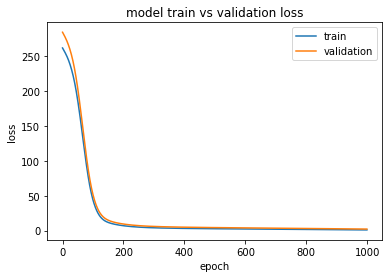

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

And these are the evaluation metrics:

The mean squared error is 2.068e+00
The R2 score is 0.988
The explained variance score is 0.988


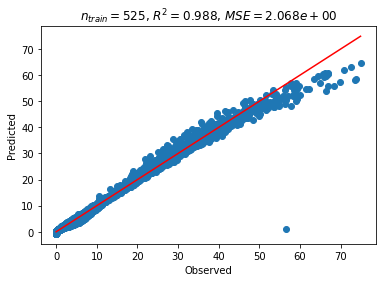

In [12]:
evaluate_model(model, X_test_scaled, y_test, n_train)

Let's now use more data and see what happens.

Train on 4201 samples, validate on 1050 samples
Epoch 1/1000
4201/4201 [==============================] - 0s 51us/step - loss: 279.4504 - val_loss: 292.7046
Epoch 2/1000
4201/4201 [==============================] - 0s 11us/step - loss: 275.7664 - val_loss: 288.5673
Epoch 3/1000
4201/4201 [==============================] - 0s 10us/step - loss: 271.6349 - val_loss: 284.0759
Epoch 4/1000
4201/4201 [==============================] - 0s 10us/step - loss: 267.1955 - val_loss: 278.9260
Epoch 5/1000
4201/4201 [==============================] - 0s 10us/step - loss: 261.9849 - val_loss: 272.9096
Epoch 6/1000
4201/4201 [==============================] - 0s 10us/step - loss: 256.0091 - val_loss: 265.7643
Epoch 7/1000
4201/4201 [==============================] - 0s 11us/step - loss: 248.7687 - val_loss: 257.2825
Epoch 8/1000
4201/4201 [==============================] - 0s 10us/step - loss: 240.0874 - val_loss: 247.2865
Epoch 9/1000
4201/4201 [==============================] - 0s 9us/step - loss: 23

4201/4201 [==============================] - 0s 8us/step - loss: 2.5980 - val_loss: 2.0674
Epoch 155/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.5741 - val_loss: 2.0542
Epoch 156/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.5537 - val_loss: 2.0336
Epoch 157/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.5290 - val_loss: 2.0023
Epoch 158/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.5078 - val_loss: 1.9917
Epoch 159/1000
4201/4201 [==============================] - 0s 9us/step - loss: 2.4876 - val_loss: 1.9797
Epoch 160/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.4670 - val_loss: 1.9391
Epoch 161/1000
4201/4201 [==============================] - 0s 9us/step - loss: 2.4455 - val_loss: 1.9050
Epoch 162/1000
4201/4201 [==============================] - 0s 8us/step - loss: 2.4194 - val_loss: 1.8886
Epoch 163/1000
4201/4201 [==============================] - 0

4201/4201 [==============================] - 0s 9us/step - loss: 1.1139 - val_loss: 0.4092
Epoch 309/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.1115 - val_loss: 0.4123
Epoch 310/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.1100 - val_loss: 0.4097
Epoch 311/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.1099 - val_loss: 0.4054
Epoch 312/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.1048 - val_loss: 0.4042
Epoch 313/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.1051 - val_loss: 0.4040
Epoch 314/1000
4201/4201 [==============================] - 0s 8us/step - loss: 1.1031 - val_loss: 0.3955
Epoch 315/1000
4201/4201 [==============================] - 0s 8us/step - loss: 1.1004 - val_loss: 0.3969
Epoch 316/1000
4201/4201 [==============================] - 0s 9us/step - loss: 1.0991 - val_loss: 0.3970
Epoch 317/1000
4201/4201 [==============================] - 0

4201/4201 [==============================] - 0s 9us/step - loss: 0.9715 - val_loss: 0.2677
Epoch 463/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9859 - val_loss: 0.2704
Epoch 464/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9829 - val_loss: 0.2700
Epoch 465/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9796 - val_loss: 0.2662
Epoch 466/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9689 - val_loss: 0.2615
Epoch 467/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9722 - val_loss: 0.2765
Epoch 468/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9701 - val_loss: 0.2581
Epoch 469/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9670 - val_loss: 0.2593
Epoch 470/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9644 - val_loss: 0.2632
Epoch 471/1000
4201/4201 [==============================] - 

4201/4201 [==============================] - 0s 8us/step - loss: 0.9298 - val_loss: 0.2256
Epoch 617/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9317 - val_loss: 0.2222
Epoch 618/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9257 - val_loss: 0.2277
Epoch 619/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9239 - val_loss: 0.2223
Epoch 620/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9337 - val_loss: 0.2349
Epoch 621/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9344 - val_loss: 0.2492
Epoch 622/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9407 - val_loss: 0.2356
Epoch 623/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9257 - val_loss: 0.2320
Epoch 624/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9319 - val_loss: 0.2359
Epoch 625/1000
4201/4201 [==============================] - 0

4201/4201 [==============================] - 0s 8us/step - loss: 0.9048 - val_loss: 0.2067
Epoch 771/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9054 - val_loss: 0.2081
Epoch 772/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9089 - val_loss: 0.2216
Epoch 773/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9139 - val_loss: 0.2095
Epoch 774/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9067 - val_loss: 0.2077
Epoch 775/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9088 - val_loss: 0.2141
Epoch 776/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9061 - val_loss: 0.2072
Epoch 777/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.9064 - val_loss: 0.2072
Epoch 778/1000
4201/4201 [==============================] - 0s 11us/step - loss: 0.9035 - val_loss: 0.2071
Epoch 779/1000
4201/4201 [=============================

4201/4201 [==============================] - 0s 8us/step - loss: 0.9097 - val_loss: 0.2132
Epoch 925/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9046 - val_loss: 0.2003
Epoch 926/1000
4201/4201 [==============================] - 0s 8us/step - loss: 0.9081 - val_loss: 0.2139
Epoch 927/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.9018 - val_loss: 0.2010
Epoch 928/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.8924 - val_loss: 0.2015
Epoch 929/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.8958 - val_loss: 0.2076
Epoch 930/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.8978 - val_loss: 0.2027
Epoch 931/1000
4201/4201 [==============================] - 0s 10us/step - loss: 0.8925 - val_loss: 0.2003
Epoch 932/1000
4201/4201 [==============================] - 0s 9us/step - loss: 0.8932 - val_loss: 0.1997
Epoch 933/1000
4201/4201 [==============================] -

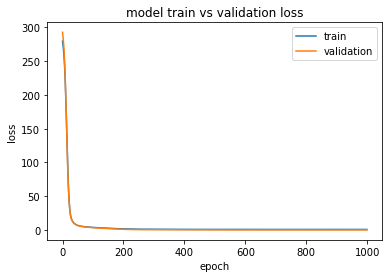

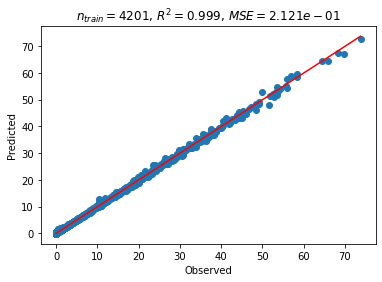

In [13]:
# split data
train_size = .8
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
model, history = make_nn(X_train_scaled, y_train, (X_test_scaled, y_test))

# evolution
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# results
evaluate_model(model, X_test_scaled, y_test, n_train)

Let's define function to plot the outputs.

In [14]:
def make_reg_plot(scaler, reg, variables, x3, labels, bounds):

    column_names = [col for col in points.columns]

    indices =  [column_names.index(name) for name in variables]

    xx = np.meshgrid(np.arange(bounds[0][0], bounds[0][1], 0.02),
                          np.arange(bounds[1][0], bounds[1][1], 0.02))

    n = len(xx[0].ravel())
    xx.append(x3 * np.ones(n))

    XX = np.empty((n, 3))
    for index, xx_ in zip(indices, xx):
        XX[:, index] = xx_.ravel()

    XX_scaled = scaler.transform(XX)

    Y = reg.predict(XX_scaled)
    Y = Y.reshape(xx[0].shape)

    # plot
    fig, ax = plt.subplots()
    cs = ax.contourf(xx[0], xx[1], Y, alpha=0.8, cmap=plt.get_cmap('jet'))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('%s = %.2g' % (labels[2], x3))
    fig.colorbar(cs)

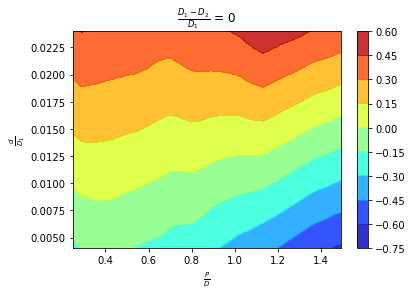

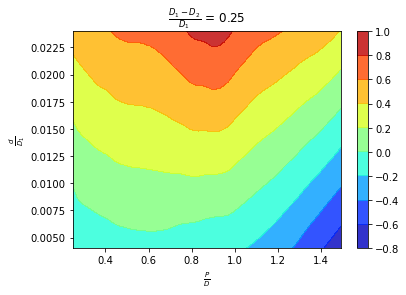

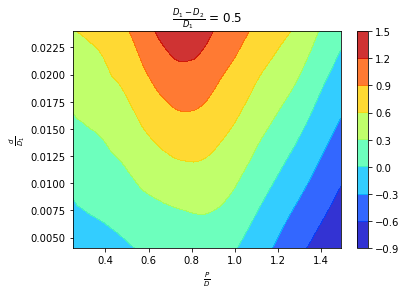

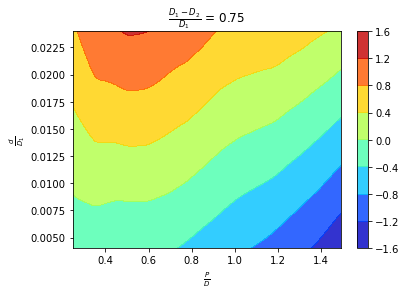

In [16]:
variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
bounds = [data['doe_variables'][name] for name in variables]
bounds[1] = [0.004, 0.025]

for x3 in [0., 0.25, 0.5, 0.75]:
    make_reg_plot(scaler, model, variables, x3, labels, bounds)